# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [175]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import itertools
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [762]:
class Point:
    def __init__(self, X, x, current_index):
        self.x_=x
        self.cur_index_= current_index
        self.distance_list = self.l2_norm(X)
        self.is_visited = False
        self.type = None
        self.cluster_number = -1
    
    def l2_norm(self, X):
        return ss.distance.cdist([self.x_], X, 'euclidean')
    
    def neighbours(self, eps):
        return   ((self.distance_list < eps) & (self.distance_list !=0))[0,:]
    
    def mean_neighbour_distance(self, min_pts):
        k= min_pts+1 # Чтобы не выкидывать себя из массива
        return np.sum(self.distance_list[0, np.argsort(self.distance_list[0])[:k]])/min_pts
        #return self.distance_list[0, np.argsort(self.distance_list[0])[:k]]


In [763]:
p = Point(x_iris, x_iris[1], 1)
p.mean_neighbour_distance(3)
#p.distance_list
# for t in p.points_[p.neighbours(0.5)]:
#     print(t.cur_index_)

0.15201593107716921

In [769]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    TYPE_CORE_POINT = 0
    TYPE_BORDER_POINT=1
    TYPE_NOISE=2
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, X, min_pts=3, eps=0.5):
        self.points_ = self.init_points(X)
        self.X_ = X
        self.min_pts_ = min_pts
        self.eps_ = eps
        self.new_cluster = itertools.count().__next__
        
        """
        Please add necessary algoritm parameters to class constructor.
        """
        return None
    
    def init_points(self, X):
        return np.array([Point(X, X[index], index) for index in range(X.shape[0])])
        
    def fit(self):
        """
        Use data matrix x to compute model parameters
        """
        for point in self.points_:
            if point.is_visited == False:
                point.is_visited = True
                #print(point.cur_index_)
                nbrs = self.points_[(point.neighbours(self.eps_))]
                #print([x.cur_index_  for x in  nbrs])
                if nbrs.shape[0] < self.min_pts_:
                    point.type = self.TYPE_NOISE
                else:
                    c = self.new_cluster()
                    #nbrs = [x for x in nbrs if x.is_visited == False]
                    #print(nbrs)
                    self.expand_cluster(point, nbrs.tolist(), c)
        return self
    
    def expand_cluster(self, point, nbrs, c):
        point.cluster_number = c
        for nbr in nbrs:
            if nbr.is_visited == False:
                nbr.is_visited = True
                nbrs1 = self.points_[nbr.neighbours(self.eps_)]
                if nbrs1.shape[0] >= self.min_pts_:
                    #nbrs1 = [x for x in nbrs1 if x.is_visited == False]
                    nbrs.extend(nbrs1.tolist())
               # print('len nbrs- ' + str(len(nbrs)))
            #print([x.cur_index_ for x in nbrs1])
            if nbr.cluster_number == -1:
                nbr.cluster_number = c
                nbr.type = self.TYPE_BORDER_POINT
    
    def predict(self, x):
        return  [x.cluster_number for x in self.points_]
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return [random.randint(0,5) for r in range(self.x_len)]
    
    def fit_predict(self):
        self.fit()
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

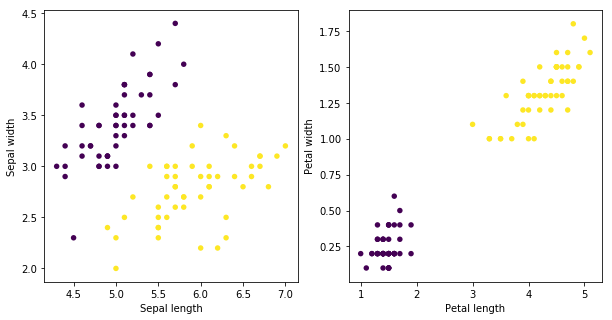

In [765]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))
pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris,  lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)

pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris,  lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [766]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(iris.data[:100])

In [767]:
# a = Clustering(x_iris[:100], 4, 0.52)
# a.fit()
# print(a.points_.shape[0])
# for point in a.points_:
#    # if point.type != 2:
#     print(point.cluster_number)

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [770]:
model = Clustering(x_iris[:100], 4, 0.52)
pred_iris = model.fit_predict()
print(pred_iris)
#print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1]


### Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

In [696]:
#for point in model.points_:
#    print(point.mean_neighbour_distance(model.min_pts_))

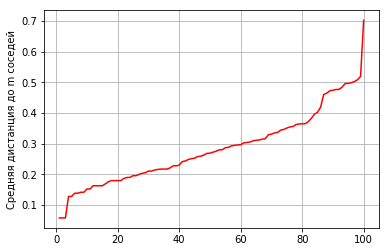

In [698]:
mean_dist_list = []
for point in model.points_:
    mean_dist_list.append(point.mean_neighbour_distance(model.min_pts_))    
mean_dist_list.sort()

plt.plot(range(1, len(mean_dist_list) + 1), mean_dist_list, color='r')

plt.xlabel('')
plt.ylabel('Средняя дистанция до m соседей')
pl.grid(True)
plt.show()

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

In [803]:
cls = Clustering(x_iris, 17, 0.52)
y =cls.fit_predict()
print(y)
print(quality(y, y_iris))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
0.882416564289


In [837]:
for eps in np.linspace(0,1,10):
    print(eps)

0.0
0.111111111111
0.222222222222
0.333333333333
0.444444444444
0.555555555556
0.666666666667
0.777777777778
0.888888888889
1.0


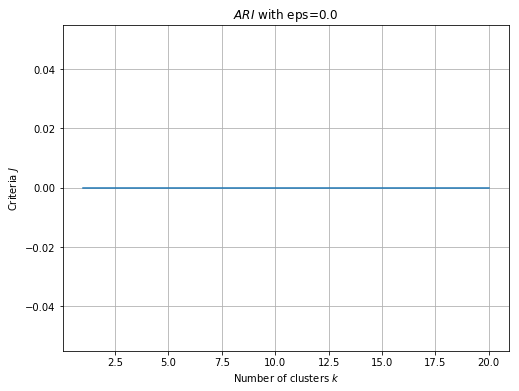

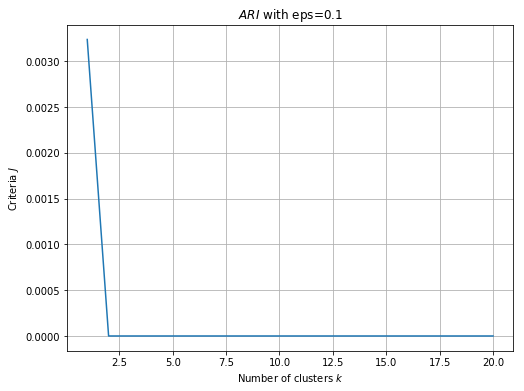

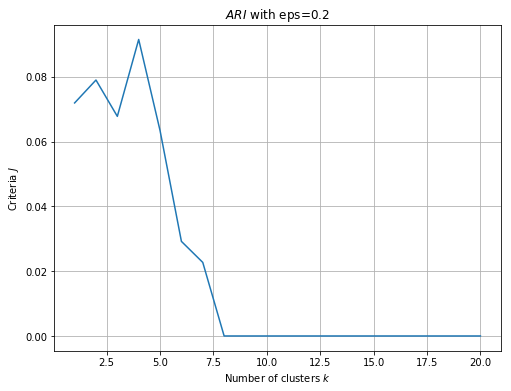

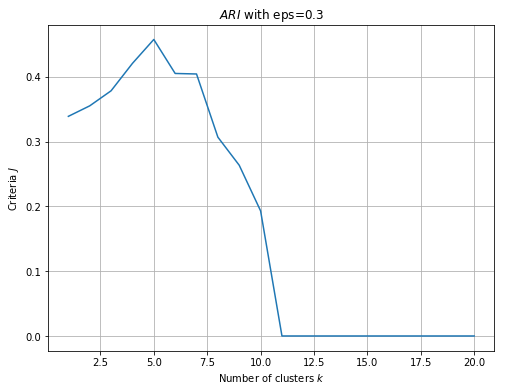

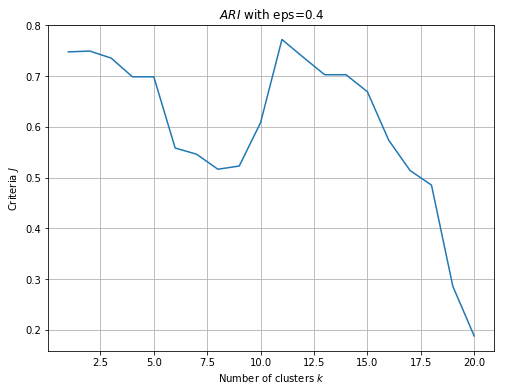

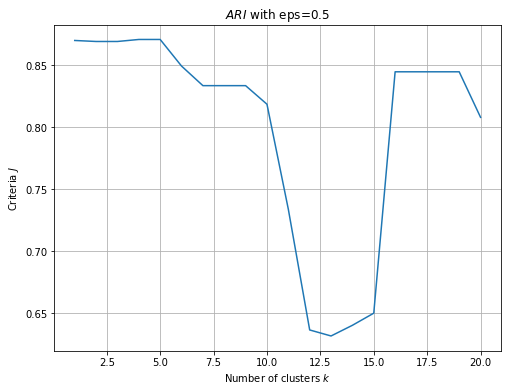

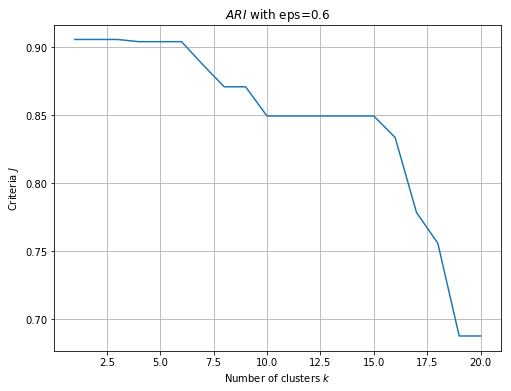

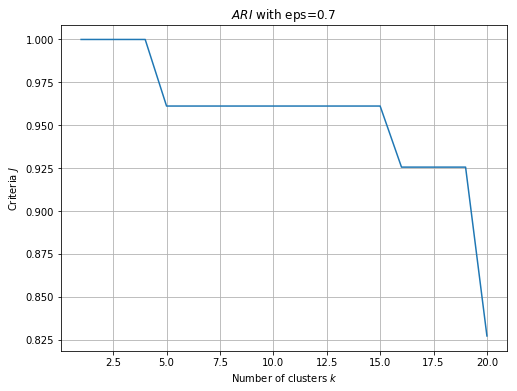

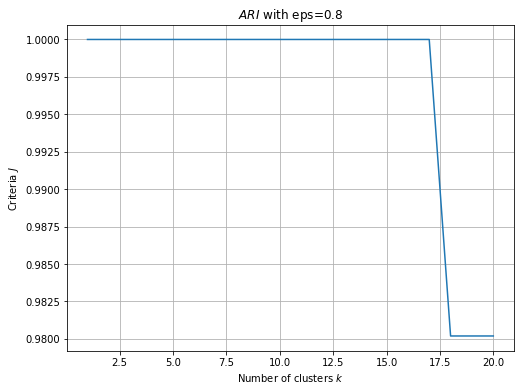

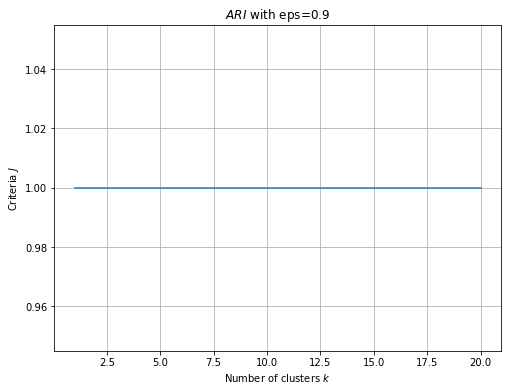

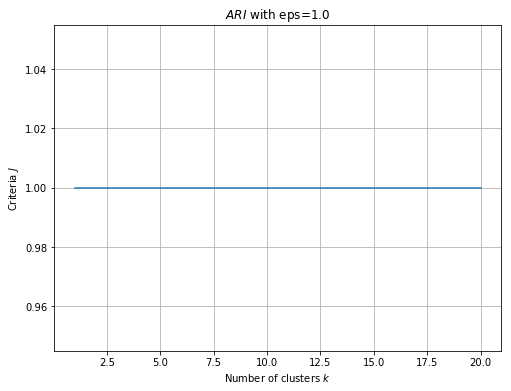

In [840]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

def quality(x, y):
    return smt.adjusted_rand_score(x, y)
for eps in np.linspace(0,1,11):
    for i, min_pts in enumerate(ks):
        cls = Clustering(x_iris, min_pts, eps)
        y = cls.fit_predict()
        criteria[i] = quality(y_iris, y)
    
    pl.figure(figsize=(8, 6))
    pl.plot(ks, criteria)
    pl.title(" with eps=" + str(eps))
    pl.ylabel("Criteria $ARI$")
    pl.xlabel("Number of clusters $k$")
    pl.grid()
    pl.show()


Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

##Кастомная реализация DBSCAN

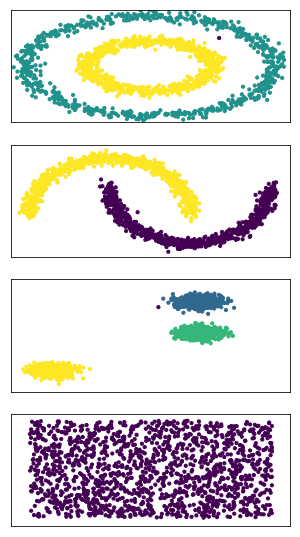

In [841]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))
data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    db_custom = Clustering(X, 5, 0.2)
    y_db_custom = db_custom.fit_predict()
    # plot

    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_db_custom)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

## DBSCAN from sklearn

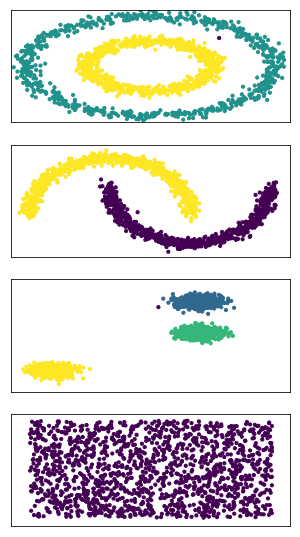

In [842]:
plt.figure(figsize=(2 + 3, 9.5))
data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=0.2,
                min_samples=5,
                metric='euclidean')
    y_db = db.fit_predict(X)
    # plot

    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=y_db)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.